# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [54]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from keras.src.optimizers import Adam



## Data Preparation

In [43]:
# Beispiel Daten laden
data = pd.read_csv('./../Data/preprocessed_df.csv') # Pfad zu Ihren Daten

print(data.head())

# Daten skalieren
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Dimension der Eingabedaten
input_dim = data_scaled.shape[1]

   participant_id  test_id  test_duration  mental  physical  temporal  \
0               1        1      33.643950      10         5        15   
1               1        2      28.484322      50        30        25   
2               1        3      71.423823     100        10        75   
3               1        4      38.163442      60        15        45   
4               2        1      41.748047      20        10        20   

   performance  effort  frustration  mean  mean_pupil_diameter  \
0           25      25           10  15.0            43.855534   
1           50      15           25  32.5            42.935538   
2           80      90           20  62.5            44.704459   
3           50      20           25  35.8            45.762156   
4           10      20           15  15.8            31.492393   

   median_pupil_diameter  blinkrate  fixationrate  
0              43.893976   0.059446      0.295946  
1              43.021599        NaN      0.175533  
2       

## GAN Definition

In [48]:
def build_generator(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(256, activation='relu'))    
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(input_dim, activation='tanh'))
    return model

## Discriminator Definition

In [49]:
def build_discriminator(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

## Build Model

In [51]:
# Erstelle Generator und Diskriminator
generator = build_generator(input_dim)
discriminator = build_discriminator(input_dim)

# Eingabe für Generator
noise = Input(shape=(input_dim,))
generated_data = generator(noise)

# Nur Diskriminator ist trainierbar für GAN-Training
discriminator.trainable = True
generator.trainable = False

# Lasse Diskriminator generierte Daten bewerten
logits = discriminator(generated_data)

# Kombiniertes GAN-Modell
gan = tf.keras.models.Model(noise, logits)

# Kompiliere Modelle vor dem Training
disc_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
disc_loss = 'binary_crossentropy'
discriminator.compile(optimizer=disc_optimizer, loss=disc_loss, metrics=['accuracy'])

gen_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.trainable = False
gan.compile(optimizer=gen_optimizer, loss=disc_loss)

## Training

In [53]:

# Hyperparameter
epochs = 200
batch_size = 32

# Lade und normalisiere die Trainingsdaten
X_train = data_scaled # Deine 144 Trainingsdatenpunkte als Numpy-Array

# Binäre Ziel-Labels für den Diskriminator
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# Listen zum Aufzeichnen der Verluste
d_losses = []
g_losses = []

# Trainingsschleife
for epoch in range(epochs):
    
    # ---------------------
    #  Trainiere den Diskriminator
    # ---------------------
    
    # Wähle eine zufällige Batches aus den realen Daten
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train[idx]
    
    # Erzeuge Noise-Vektoren und lasse den Generator daraus Daten generieren
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    fake_data = generator.predict(noise)
    
    # Kombiniere reale und gefälschte Daten und trainiere den Diskriminator
    d_loss_real = discriminator.train_on_batch(real_data, valid)
    d_loss_fake = discriminator.train_on_batch(fake_data, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # ---------------------
    #  Trainiere den Generator
    # ---------------------
    
    # Generiere neue Noise-Vektoren
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    
    # Der Generator möchte den Diskriminator täuschen, daher verwenden wir gültige Labels
    g_loss = gan.train_on_batch(noise, valid)

    # Aktualisiere die Verlust-Metriken
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    # Gib den Verlust alle 10 Epochen aus
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} - Diskriminator Verlust: {d_loss} - Generator Verlust: {g_loss}")
        
# Speichere den trainierten Generator zum späteren Verwenden
#generator.save("generator.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


/Users/hennerbendig/anaconda3/envs/tf_311/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch: 0 - Diskriminator Verlust: [0.69624126 0.265625  ] - Generator Verlust: [array(0.6960994, dtype=float32), array(0.6960994, dtype=float32), array(0.3125, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch: 10 - Diskriminator Verlust: [0.6969154  0.27681953] - Generator Verlust: [array(0.6968897, dtype=float32), array(0.6968897, dtype=float32), array(0.27982953, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━

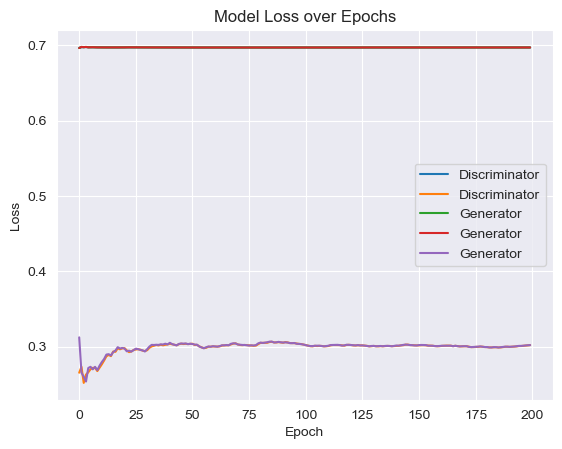

In [55]:
# Verlustkurven plotten
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Evaluation

In [56]:
def generate_new_data(generator, input_dim, num_samples=10):
    """
    Generiert neue Daten mit dem trainierten Generator des GANs.
    
    :param generator: Das trainierte Generator-Modell des GANs.
    :param num_samples: Die Anzahl der Datensätze, die generiert werden sollen.
    :param input_dim: Die Dimension des latenten Raumes.
    :return: Ein Array generierter Daten.
    """
    # Erzeugen der Zufallseingaben (Rauschen) für den Generator
    noise = np.random.normal(0, 1, (num_samples, input_dim))
    
    # Verwende den Generator, um aus dem Rauschen neue Daten zu erzeugen
    generated_data = generator.predict(noise)

    # Skaliere die Daten zurück
    generated_data = scaler.inverse_transform(generated_data)
    
    generated_data = pd.DataFrame(generated_data, columns=data.columns)
    
    return generated_data


In [57]:
num_samples_to_generate = 5  
generated_data = generate_new_data(generator, num_samples=num_samples_to_generate, input_dim=input_dim)

print("Generated Data:")
print(generated_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
Generated Data:
   participant_id   test_id  test_duration     mental   physical   temporal  \
0        0.942945  1.459571    -989.575684  15.335613  26.279930  27.548824   
1       -0.423818  1.585452   -1669.332764  13.284020   2.081206   8.060483   
2      -12.246123  1.377423   -1971.187134  37.274426   9.701530  13.713245   
3      -10.937928  1.770860   -1584.036987   7.405968   7.484325   5.109419   
4      -15.585541  1.305880   -2273.764404  19.202919   9.996023   1.125461   

   performance     effort  frustration       mean  mean_pupil_diameter  \
0   -18.780962  -8.096638    15.610783 -14.385547            23.927153   
1     3.326133 -18.269440    26.502623   2.629688            30.584126   
2   -32.123741   6.437636     2.079922 -27.624586            28.307060   
3   -20.318270 -10.379754    -1.442544  -0.889261            28.796675   
4   -17.242903  -9.844510    21.581928 -17.230715            24.903128   

   median_pupil_diameter 